(ex-circuit-sampling)=

# Exploring circuit sampling with various methods

This example shows some typical explorations and methods for simulating a quantum circuit on an arbitrary set of edges.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import tqdm
import numpy as np
import cotengra as ctg
import quimb as qu
import quimb.tensor as qtn

First we define some edges and the gates that go into each layer:

In [2]:
# define some edges
edges = qtn.edges_2d_hexagonal(5, 5)

# get all unique sites, sorted
sites = sorted({site for edge in edges for site in edge})
N = len(sites)

# map each site coordinate to a linear register
sitemap = {
    site: i for i, site in enumerate(sites)
}

def gen_layer_gates():
    for site in sites:
        yield qtn.Gate("RX", params=(0.2,), qubits=(sitemap[site],))
    for sitea, siteb in edges:
        yield qtn.Gate("RZZ", params=(-0.3,), qubits=(sitemap[sitea], sitemap[siteb]))
    for site in sites:
        yield qtn.Gate("RZ", params=(0.4,), qubits=(sitemap[site],))

Then create an actual sequence of gates to test with:

In [3]:
depth = 6
gates = []
for _ in range(depth):
    gates.extend(gen_layer_gates())

## check exact contraction

The first thing we might check is whether the circuit is exactly contractible.

Create our circuit:

In [6]:
circ = qtn.Circuit(N)
circ.apply_gates(gates)
circ

<Circuit(n=50, num_gates=990, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

Crucially, we create a high qualty contraction optimizer that we can reuse:

In [7]:
opt = ctg.ReusableHyperOptimizer(
    minimize="combo",  # target both flops and mops
    reconf_opts={},  # perform subtree reconfiguration refinement
    parallel=True,  # optimize in parallel
    optlib="cmaes",  # an efficient parallel meta-optimizer
    max_time="rate:1e8",  # don't spend time optimizing cheap contractions
    hash_method="b",  # most generous cache hits
    directory=True,  # cache paths to disk
    progbar=True,  # show live progress
)

# # the random greedy optimizer might be better for targeting higher
# # throughput (i.e. cheap but many) contractions, especially if you have
# # `cotengrust` installed (https://github.com/jcmgray/cotengrust)
# opt = "random-greedy"

The most important cost to check is that of a single amplitude:

In [8]:
rehs = circ.amplitude_rehearse(optimize=opt)

F=9.48 C=9.89 S=24.00 P=25.00:  98%|█████████▊| 125/128 [00:31<00:00,  4.02it/s]


To actually sample unbiasedly, but bounded by this cost, one can use **'gate by gate'** sampling.
Here there is a number of contractions proportional to circuit depth, divided by `group_size`.
`group_size` being the maximum number of qubits we want to compute marginals for simultaneously.

First 'rehearsing' the costs:

In [9]:
rehs = circ.sample_gate_by_gate_rehearse(group_size=17, optimize=opt)

F=9.44 C=9.76 S=24.00 P=24.36:  71%|███████   | 91/128 [00:27<00:11,  3.25it/s] 


The we can actually run the sampling algorithm. Simplifications are data dependent, i.e. might produce slightly different TN geometries, so we might see the optimizer running a few more times here:

In [10]:
%%time

rng = np.random.default_rng(42)

for b in circ.sample_gate_by_gate(10, group_size=17, optimize=opt, seed=rng):
    print(b)

F=7.86 C=8.26 S=19.00 P=19.81:   4%|▍         | 5/128 [00:01<00:32,  3.84it/s]  


00000000000000000111000111010010111001000101001100


F=7.75 C=8.15 S=18.00 P=19.32:   1%|          | 1/128 [00:00<01:23,  1.52it/s]


00000000110000000000010001010100001110000010001001


F=7.91 C=8.39 S=20.00 P=20.59:   2%|▏         | 3/128 [00:01<00:44,  2.82it/s] 


00100000000001110100101011001010110010010000010010


F=7.74 C=8.25 S=19.00 P=20.17:   2%|▏         | 2/128 [00:00<00:42,  2.96it/s]


00000000000000001100000000001000000000010000000100
01100010111100000000000110001000001100010101000101


F=7.72 C=8.25 S=18.00 P=19.05:   1%|          | 1/128 [00:00<01:23,  1.51it/s]


00000000010000000011100000000000000000011000000000
00000000000000001001100001100110000000110000000000
10001000000000000010100000100000000000000001000001


F=7.46 C=8.04 S=17.00 P=18.09:   0%|          | 0/128 [00:00<?, ?it/s]


10000000110100000001000000000000111100010001011010
00000011000001100000100100000000000000000000000000
CPU times: user 3min 50s, sys: 18.4 s, total: 4min 8s
Wall time: 42.7 s


We can also check **'qubit-by-qubit'** sampling:

In [11]:
rehs = circ.sample_rehearse(group_size=17, optimize=opt)

F=9.60 C=9.88 S=24.00 P=24.64:  88%|████████▊ | 112/128 [00:40<00:05,  2.77it/s]


For shallow circuits the total cost might be better, but here these costs are much higher.

### check advanced simplifications

One thing worth checking, is if advanced TN simplification methods might reduce the contraction complexity more than the default setting (usually not the case).

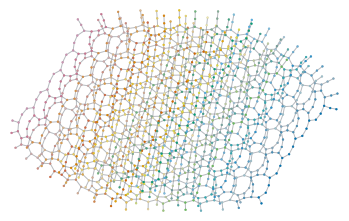

In [12]:
# explicitly get the unsimplified TN
tn = circ.amplitude_tn(simplify_sequence="")
tn.draw(tn.site_tags, layout="neato")

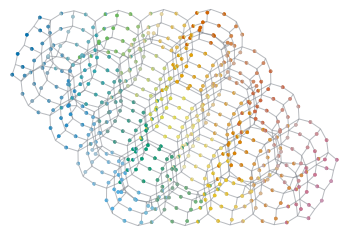

In [ ]:
# compare with default simplifications
tn_fs = circ.amplitude_tn()
tn_fs.draw(tn.site_tags, layout="neato")

Get a rough estimate of its contraction complexity, the `'random-greedy'` optimizer is very quick and medium quality for such estimates:

In [ ]:
qu.log10(tn_fs.contraction_cost(optimize="random-greedy"))

9.886418822840847

Then we can try the more advanced method (this is also what you would use to prepare the TN for compressed contraction, thus the name):

In [15]:
tn_cs = tn.compress_simplify(output_inds=(), progbar=True)

S 636, 296: : 10it [00:00, 60.87it/s]   
L 680, 1020: : 6it [00:00,  9.89it/s]   
S 565, 293: : 10it [00:00, 33.57it/s]  
L 672, 1008: : 6it [00:00,  9.59it/s]   
S 450, 293: : 10it [00:00, 82.32it/s]  
L 672, 1008: : 6it [00:00,  9.42it/s]  
S 440, 293: : 10it [00:00, 73.06it/s]  
L 672, 1008: : 6it [00:00,  9.61it/s]  
S 427, 293: : 10it [00:00, 75.72it/s]  
L 672, 1008: : 6it [00:00,  9.77it/s]  
S 421, 293: : 10it [00:00, 78.35it/s]  
L 672, 1008: : 6it [00:00,  9.60it/s]  
S 420, 293: : 10it [00:00, 80.25it/s]  


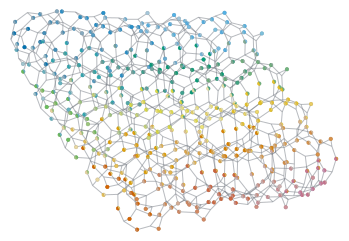

In [16]:
tn_cs.draw(tn.site_tags, layout="neato")

In [ ]:
qu.log10(tn_cs.contraction_cost(optimize="random-greedy"))

10.599551819716632

So the advanced simplifications have made a smaller TN but not probably not improved the overall contraction cost.

## check MPS simulation

If the geometry is close-ish to 1D, the simulating with an MPS might be more efficient.

In [18]:
circ = qtn.CircuitMPS(len(sites))
circ.apply_gates(gates, progbar=True)

max_bond=286, error~=1.39e-07: 100%|##########| 990/990 [00:20<00:00, 48.35it/s] 


In [19]:
circ.psi.show()

     2 4 8 15 25 43 72 117 190 273 270 267 255 262 252 261 256 268 271 286    
... >─>─>─>──>──>──>──>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━ ...
    │ │ │ │  │  │  │  │   │   │   │   │   │   │   │   │   │   │   │   │       
                                 ...                                  
     273 268 257 262 254 262 257 268 271 286 273 269 257 261 252 261 256 2    
... >━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━━━>━ ...
    │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │     
                                 ...                                  
    68 271 284 199 122 73 43 25 15 8 4 2 
    ━━>━━━>━━━>━━━>━━━>──>──>──>──>─>─>─●
      │   │   │   │   │  │  │  │  │ │ │ │


In [20]:
%%time

rng = np.random.default_rng(42)

for b in circ.sample(10, seed=rng):
    print(b)

10100110000111000000101100000011000000000100010000
00100000000000000000000000000100000000000000000001
10011000010000000000000000000001000010000011000000
11000000010100000001000100011011000000001001000100
11000000000000000010000101000000101100001100010000
01000010000100100000000000000100000000001010111100
10001000000000000001100000000010010000010110011000
00000011001000001001100000100001100111010000001000
01101101010001000001000000000111000000001000001100
01100010100010000100000000000000000000000000000000
CPU times: user 6.97 s, sys: 93 ms, total: 7.06 s
Wall time: 1.1 s


For this particular circuit, it is very efficiently handled by an MPS.

## check PEPS simulation

If the geometry is not close to 1D we can try simulatig with a PEPS. In
particular, if the amount of loop correlations is small, we can try using the
very cheap "simple update" style evolution method.

First we setup the PEPS:

In [4]:
# vacuum state
peps = qtn.TN_from_sites_product_state({site: [1.0, 0.0] for site in sitemap.values()})

# create size 1 bonds
for sitea, siteb in edges:
    i = sitemap[sitea]
    j = sitemap[siteb]
    peps[i].new_bond(peps[j])

Next we apply the gates to the PEPS, using the SU gauge:

In [5]:
gauges = {}

for gate in tqdm.tqdm(gates):
    peps.gate_simple_(
        gate.array,
        gate.qubits,
        gauges=gauges,
        # this is a crucial paramter - the maximum bond dimension
        max_bond=16,
        cutoff=1e-6,
        cutoff_mode="rel",
        renorm=False,
    )

100%|██████████| 990/990 [00:00<00:00, 2301.38it/s]


Now we have the PEPS. Note if we didn't have commuting two qubit gates we might want to use
[`qtn.edge_coloring`](quimb.tensor.tensor_arbgeom_tebd.edge_coloring) to get an effective trotterization.

In [6]:
# the state normalization gives us an idea of fidelity
peps.normalize_simple(gauges)

0.9999970536698275

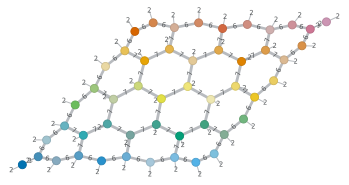

In [8]:
peps.draw(peps.site_tags, show_inds="bond-size")

In [9]:
# equilibrate gauges
peps.gauge_all_simple_(100, tol=1e-9, gauges=gauges, progbar=True)

max|dS|=1.49e-10, nfact=0.00: : 1it [00:00, 24.01it/s]


TensorNetworkGenVector(tensors=50, indices=115)

To keep this cheap we can evaluate local observables or sample configurations
using the 'cluster' method, where beyond a local region the simple update style
gauges are used to approximate the environment (exact on trees).

In [27]:
peps.local_expectation_cluster(
    G=qu.pauli("Z") & qu.pauli("Z"),
    where=tuple(sitemap[site] for site in edges[10]),
    gauges=gauges,
    # increase this to include loops and check for convergence
    max_distance=0,
)

array(0.34701078-1.83418952e-18j)

We can also sample via the simple update style approximation:

In [28]:
%%time

rng = np.random.default_rng(42)

for _ in range(10):
    config, omega = peps.sample_configuration_cluster(
        gauges=gauges,
        seed=rng,
        # single site clusters
        max_distance=0,
    )
    x = "".join(map(str, (config[i] for i in range(N))))
    print(x)

00000000000000000000000100110011001100000011000101
00001100000000000000100000000000000000000000000000
00000000000000110000000000010100100011010100000000
01011001000010001000001000000100000011001100010100
10011100011000000000000000000100001110001100000100
10000000010000000000100001110000000110011000000001
10000101111110000101000001100000000000000000000000
00000010000000011000100000000101000000000001000011
11011000100110011001001000010000000010001101000110
10000011000001110000000000000000000010000000000000
CPU times: user 23.3 s, sys: 32.4 ms, total: 23.4 s
Wall time: 23.4 s


If one contracts the amplitude associated with `config`, then its ratio to the 'local' probability `omega` allows one to do unbiased sampling.

In [29]:
# clean up the contraction cache for docs
!rm -rf ctg_cache/